In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import npeet.entropy_estimators as ee
from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn import datasets
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import entropy

In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import mixed

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import tree

In [4]:
# Taken from Richard's "Reprod Figure 2"
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), int((1 - max_samples)*len(X)))
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

/Users/ronak/miniconda3/envs/mgc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
def generate_data(n):
    
    # Class sizes.
    n_0 = np.random.binomial(n, 0.5, 1)[0]
    n_1 = n - n_0
    
    # Generate uniform spiral.
    theta = np.random.uniform(0.0, 5*np.pi, size=n_0).reshape(-1, 1) # TODO change to uniform sampling.
    X_0 = np.concatenate((2*np.cos(theta), 2*np.sin(theta), 5*theta / np.pi - 10), axis = 1)
    y_0 = np.repeat(0, n_0)
    
    # Generate fuzzy stick.
    sigma = 0.05
    zeros = np.zeros((n_1, 1))
    X_1 = np.concatenate((zeros, zeros, np.random.uniform(-10, 10, n_1).reshape(-1, 1)), axis = 1)
    X_1 += np.random.multivariate_normal(np.zeros(3), sigma*np.eye(3), n_1)
    y_1 = np.repeat(1, n_1)
    
    X = np.concatenate((X_0, X_1), axis = 0)
    y = np.concatenate((y_0, y_1), axis = 0)                  
    
    return X, y

In [6]:
# def split_train_eval(X, y, frac_eval):
    
#     if frac_eval == 0:
#         return X, y, [], []
    
#     n = len(y)
#     n_eval = int(np.floor(frac_eval*n))
#     eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
#     X_eval = X[eval_indices, :]
#     y_eval = y[eval_indices]
#     X = np.delete(X, eval_indices, axis = 0)
#     y = np.delete(y, eval_indices, axis = 0)
    
#     return X, y, X_eval, y_eval

In [7]:
def plot_setting(X, y):
    colors = np.array(["#2166ac", "#c51b7d"])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.gca(projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2], s=100, c=colors[y], depthshade=True)

    # Remove background.
    # Get rid of colored axes planes
    # First remove fill
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    # ax.grid(False)

    plt.savefig("fig6_3D.pdf")
    plt.show()

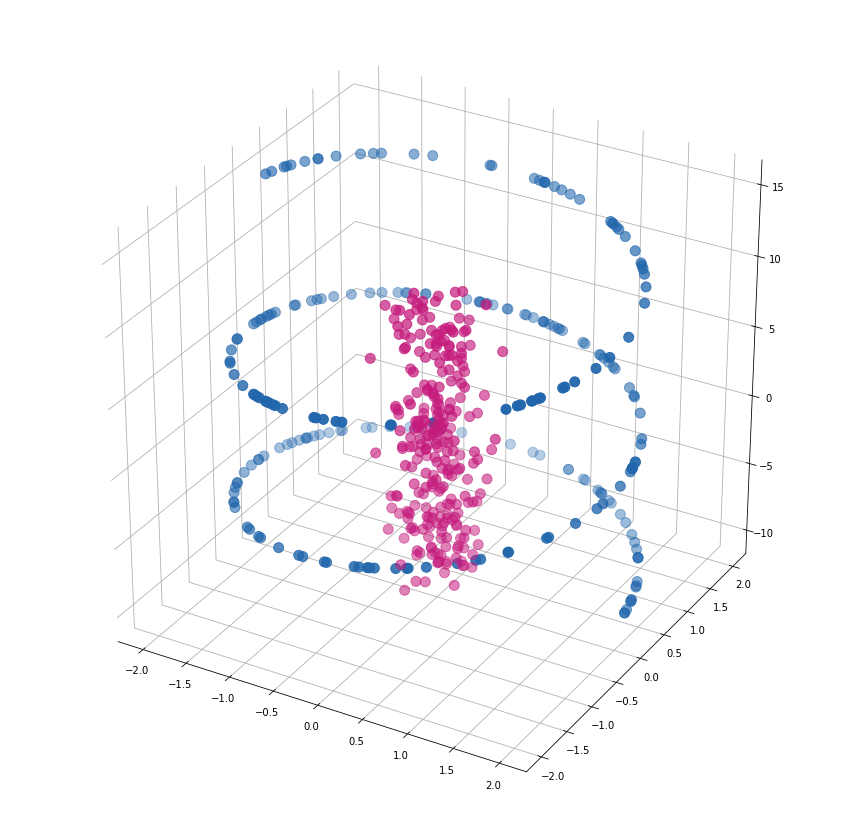

In [8]:
n = 500

X, y = generate_data(n)
plot_setting(X, y)

In [9]:
def estimate_mi(X, y, label, base = np.exp(1)):
    _, counts = np.unique(y, return_counts=True)
    est_H_Y = entropy(counts, base=np.exp(1))
        
    if label == "UF":
        # UF
        return (est_H_Y - cef_estimate(np.array(X), y, 300, .32, depth = 30))
        
        # CART
        # cart_out = CART_estimate(X, y)
    elif label == "IRF":    
        # IRF
        frac_eval = 0.3
        irf_obj = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = frac_eval)
        irf_obj.fit(X_train, y_train)
        p = irf_obj.predict_proba(X_eval)
        return (est_H_Y - np.mean(entropy(p.T, base = base))) 
    elif label == "KSG": 
        # KSG
        return ee.mi(X, np.array(y).reshape(-1, 1))
    elif label == "Mixed KSG":     
        # MKSG
        return mixed.Mixed_KSG(X, y.reshape(-1, 1))
    else:
        raise ValueError("Uncrecognized label!")

In [10]:
# def mutual_info_dist(n, frac_eval, algos, num_trials, parallel):
#     # For each trial, generate data and compute conditional entropy for each algorithm.
#     def worker(t):
#         X, y = generate_data(n)
#         X, y, X_eval, _ = split_train_eval(X, y, frac_eval)
        
#         ret = np.zeros(len(algos))
#         for j in range(len(algos)):
#             # Estimate conditional probability of Y | X.
#             ret[j] = estimate_mi(X, y, algos[j]['label'], algos[j]['instance'], frac_eval)
#         return ret
    
#     if parallel:
#         predicted_mutual_info = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
#     else:
#         predicted_mutual_info = np.zeros((num_trials, len(algos)))
#         for t in tqdm_notebook(range(num_trials)):
#             predicted_mutual_info[t, :] = worker(t)
            
#     return predicted_mutual_info

# def mutual_info_by_n(sample_sizes, frac_eval, algos, num_trials, parallel = False):
#     # Repeat for all 'n', and save output in the 'algos' array.
#     mutual_info_range = np.zeros((len(sample_sizes), num_trials, len(algos)))
#     for i in range(len(sample_sizes)):
#         mutual_info_range[i, :, :] = mutual_info_dist(sample_sizes[i],
#                                                       frac_eval, 
#                                                       algos, 
#                                                       num_trials,
#                                                       parallel = parallel)
        
#     for j in range(len(algos)):
#         algos[j]['mutual_info_by_n'] = mutual_info_range[:, :, j]
        
#     with open('algos_fig6.pkl', 'wb') as f:
#         pickle.dump(algos, f)
#     with open('sample_sizes_fig6.pkl', 'wb') as f:
#         pickle.dump(sample_sizes, f)

In [11]:
def get_mutual_info_vs_n(sample_sizes, num_trials, base = np.exp(1)):
    
    num_n = len(sample_sizes)
    uf = np.zeros((num_n, num_trials))
    irf = np.zeros((num_n, num_trials))
    ksg = np.zeros((num_n, num_trials))
    mksg = np.zeros((num_n, num_trials))
    results = [uf, irf, ksg, mksg]
    
    def worker(t):
        X, y = generate_data(elem)
        
        uf_out = estimate_mi(X, y, 'UF')
        irf_out = estimate_mi(X, y, 'IRF')
        ksg_out = estimate_mi(X, y, 'KSG')
        mksg_out = estimate_mi(X, y, 'Mixed KSG')
        
        return (uf_out, irf_out, ksg_out, mksg_out)
    
    for i, elem in enumerate(sample_sizes):
        # num_trials by num_algos
        output = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        uf[i, :] = output[:, 0]
        # cart[i, :] = output[:, 1]
        irf[i, :] = output[:, 1]
        ksg[i, :] = output[:, 2]
        mksg[i, :] = output[:, 3]
        
    pickle.dump(sample_sizes, open('sample_sizes.pkl', 'wb'))
    pickle.dump(uf, open('uf_by_n.pkl', 'wb'))
    pickle.dump(irf, open('irf_by_n.pkl', 'wb'))
    pickle.dump(ksg, open('ksg_by_n.pkl', 'wb'))
    pickle.dump(mksg, open('mksg_by_n.pkl', 'wb'))

    return uf, irf, ksg, mksg

In [12]:
# Data.
sample_sizes = range(100, 120, 10)
num_trials = 3
frac_eval = 0.3
n_estimators = 10

# Algorithms.
algos = [
    {
        'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators), 
                                           method='isotonic', 
                                           cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'instance': None,
        'label': 'KSG',
        'title': 'KSG',
        'color': "#1b9e77",
    },
    {
        'instance': None,
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "purple",
    },
    {
        'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

# Other.
num_plotted_trials = 3
parallel = True

In [13]:
# mutual_info_by_n(sample_sizes, frac_eval, algos, num_trials, parallel = parallel)
get_mutual_info_vs_n(sample_sizes, num_trials)

(array([[0.19534083, 0.20626146, 0.20513336],
        [0.22312391, 0.15606734, 0.21181017]]),
 array([[0.62299145, 0.5674648 , 0.57075546],
        [0.59044147, 0.58179257, 0.60191976]]),
 array([[0.82793495, 0.77240711, 0.72509982],
        [0.80360182, 0.77696217, 0.73479089]]),
 array([[0.2975182 , 0.25595358, 0.27694137],
        [0.35358875, 0.33970373, 0.37511835]]))

In [14]:
def plot_mutual_info_by_n(ax, algos, num_plotted_trials):
    
    sample_sizes = pickle.load(open('sample_sizes.pkl', 'rb'))
    uf = pickle.load(open('uf_by_n.pkl', 'rb'))
    irf = pickle.load(open('irf_by_n.pkl', 'rb'))
    ksg = pickle.load(open('ksg_by_n.pkl', 'rb'))
    mksg = pickle.load(open('mksg_by_n.pkl', 'rb'))
    results = [irf, ksg, mksg, uf]
    
    for j, algo in enumerate(algos):
        # Plot the mean over trials as a solid line.
        plt.plot(sample_sizes, 
                 np.mean(results[j], axis = 1).flatten(), 
                 label = algo['label'], 
                 linewidth = 2, 
                 color = algo['color'])
        for t in range(num_plotted_trials):
            plt.plot(sample_sizes, 
                     results[j][:, t].flatten(),
                     linewidth = 2,
                     alpha = 0.15,
                     color = algo['color'])

    plt.xlabel("Sample Size")
    plt.ylabel("Estimated Mutual Info")
    plt.title("Stick and Spiral Mutual Information")
    plt.legend(loc = "lower right")
    
    plt.ylim(bottom = -0.05)
    # ax.set_ylim(top = 1.05)
    # plt.xlim(left = np.amin(sample_sizes) - 5)
    # plt.xlim(right = np.amax(sample_sizes) + 5)

In [15]:
def plot_fig5():
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    
    plt.figure(figsize=(10, 10))
    
    plot_mutual_info_by_n(algos, num_plotted_trials)

    # plt.ylim(ymin = -.05)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.tight_layout()
    plt.savefig("fig6_est.pdf")
    plt.show()

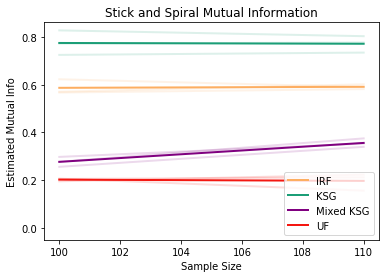

In [16]:
plot_mutual_info_by_n(sample_sizes, algos, num_plotted_trials)